In [1]:
import uproot
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import special,stats
import mplhep as hep
import boost_histogram as bh


plt.style.use("seaborn-paper")
mpl.rcParams.update({
    'font.family': 'STIXGeneral',
    # 'font.sans-serif': ['Times New Roman'],
    'mathtext.default':'rm',
    'mathtext.fontset':'stix',
    'mathtext.fallback_to_cm':False,
    "axes.titlesize" : 24,
"axes.labelsize" : 20,
"lines.linewidth" : 3,
"lines.markersize" : 10,
"xtick.labelsize" : 18,
"ytick.labelsize" : 18,
'savefig.dpi':300,
'legend.fontsize':20,
'figure.figsize':(8,6)
    })
plt.rcParams['axes.unicode_minus'] = False

/usr/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/usr/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


# Read in SM DY outputs

In [2]:
sm_dy = np.load("sm_dy.npz")
sm_dy.files

['hist', 'xsec', 'ticks', 'center']

In [3]:
hist = sm_dy['hist']
xs = sm_dy['xsec']

In [4]:
yields = hist * xs / 100000 * 1000000 # Scale to 1/ab

In [5]:
center = sm_dy['center']
edges = sm_dy['ticks']

Text(0.5, 1.0, 'SM Yields')

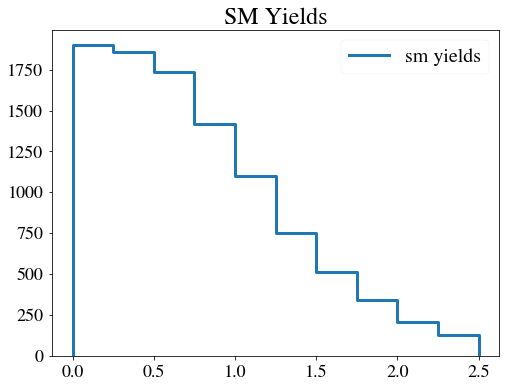

In [6]:
hep.histplot(yields,bins=edges)
plt.legend(["sm yields"])
plt.title("SM Yields")

# Writing "Fake Observations"

Here, my assumption is each bin subjects to a Poisson distribution with parameters match SM yields.

And calculate the LLR as
$$
-2\log\lambda = 2\sum_{\text{N bins}}\left(yields - obs + obs * \log(\frac{obs}{yields})\right)
$$

In [7]:
def run():
    obs = np.random.poisson(yields)
    hist = 2 * (yields - obs + obs * np.log(obs/yields))
    return hist.sum()

In [8]:
samples = [run() for i in range(1000000)]

In [9]:
bins = bins=np.linspace(0,20,200+1)

In [10]:
hist = bh.Histogram(bh.axis.Regular(200, 0, 20), storage=bh.storage.Weight())
hist.fill(samples)

Histogram(Regular(200, 0, 20), storage=Weight()) # Sum: WeightedSum(value=970476, variance=970476) (WeightedSum(value=1e+06, variance=1e+06) with flow)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f63d9ca0d00>, errorbar=None, legend_artist=None)]

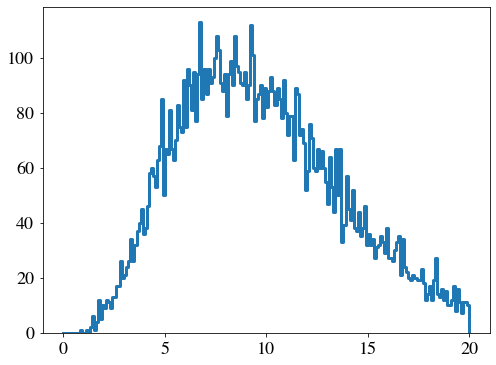

In [34]:
hist_less_stats = bh.Histogram(bh.axis.Regular(200, 0, 20), storage=bh.storage.Weight())
hist_less_stats.fill(samples[:10000])
hep.histplot(hist_less_stats.view().value, bins=hist.axes[0].edges)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f63dcf0b610>, errorbar=None, legend_artist=None)]

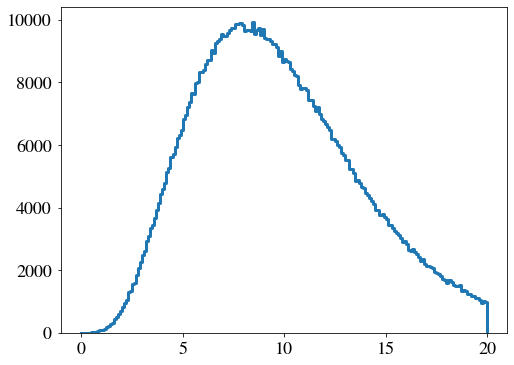

In [19]:
hep.histplot(hist.view().value, bins=hist.axes[0].edges)

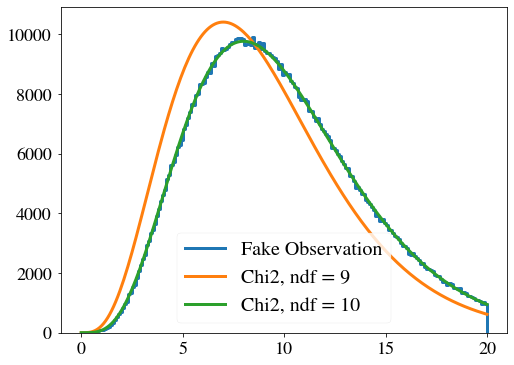

In [20]:
hep.histplot(hist.view().value, bins=hist.axes[0].edges)
pdfs_ndf10 = stats.chi2.pdf(bins,df = 10)
pdfs_ndf9 = stats.chi2.pdf(bins,df = 9)
plt.plot(bins,pdfs_ndf9*1000000/10,label = "Chi2, ndf = 9")
plt.plot(bins,pdfs_ndf10*1000000/10,label = "Chi2, ndf = 10")
# dividing 10 accounting for the binning correction to the normalization factor
plt.legend(["Fake Observation","Chi2, ndf = 9","Chi2, ndf = 10"])

# Conclusion
If we do calculation under the uncorrelated poisson assumption, we should use $\text{NDF} = 10$, namely
$$
\text{NDF} = \text{N bins}
$$

# MultiNomial Distribution Case

In [23]:
def run_multi():
    obs = np.random.multinomial(yields.sum(),yields/yields.sum())
    hist = 2 * (yields - obs + obs * np.log(obs/yields))
    return hist.sum()

In [24]:
samples_multi = [run_multi() for i in range(1000000)]

In [25]:
hist_multi = bh.Histogram(bh.axis.Regular(200, 0, 20), storage=bh.storage.Weight())
hist_multi.fill(samples_multi)

Histogram(Regular(200, 0, 20), storage=Weight()) # Sum: WeightedSum(value=981864, variance=981864) (WeightedSum(value=1e+06, variance=1e+06) with flow)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7f63dc578640>, errorbar=None, legend_artist=None)]

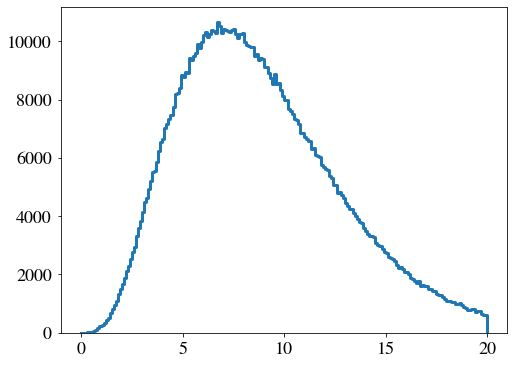

In [26]:
hep.histplot(hist_multi.view().value, bins=hist.axes[0].edges)

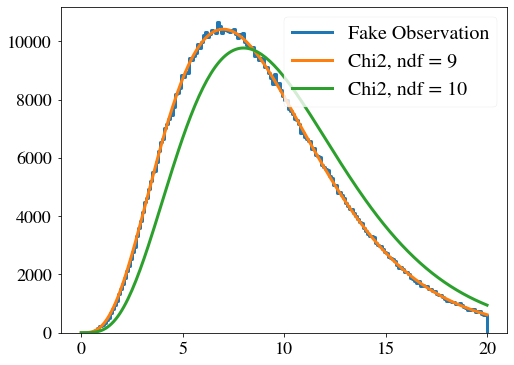

In [27]:
hep.histplot(hist_multi.view().value, bins=hist.axes[0].edges)
pdfs_ndf10 = stats.chi2.pdf(bins,df = 10)
pdfs_ndf9 = stats.chi2.pdf(bins,df = 9)
plt.plot(bins,pdfs_ndf9*1000000/10,label = "Chi2, ndf = 9")
plt.plot(bins,pdfs_ndf10*1000000/10,label = "Chi2, ndf = 10")
# dividing 10 accounting for the binning correction to the normalization factor
plt.legend(["Fake Observation","Chi2, ndf = 9","Chi2, ndf = 10"])